In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as fn
from torch.autograd import Variable
import numpy as np

In [2]:
from tqdm import tqdm_notebook

In [424]:
import gc

In [134]:
# Multi-Component word embeddings

class MultiComp(nn.Module):
    def __init__(self, word_embeddings_to_comp, n_comp=3):
        """
        word_embeddings_to_comp: word embeddings of the target word;
                                 shape = (n_words,100);
        
        """
        super(MultiComp, self).__init__()
        self.n_comp = n_comp
        
        n_words, embedding_size = word_embeddings_to_comp.shape
        # expand to duplicate embeddings n_comp times
        expanded_word_embeddings = np.expand_dims(word_embeddings_to_comp, 1)
        comp_embeddings = np.tile(expanded_word_embeddings, [1, n_comp, 1])
        
        # add some noise to components (1/3 of its standard deviations)
        stds = word_embeddings_to_comp.std(axis=1, keepdims=True).reshape([n_words, 1, 1])
        comp_embeddings += np.random.randn(n_words, n_comp, embedding_size)#  * stds  / 10
        comp_embeddings = np.random.randn(n_words, n_comp, embedding_size)#  * stds  / 10
        comp_embeddings = comp_embeddings.astype(np.float32)
        
        self.n_centroids = np.random.randn(n_words, n_comp, embedding_size)#  * stds  / 10
        self.n_centroids = self.n_centroids.astype(np.float32)
        
        # create variable to use autograd
        self.words_comps = nn.Parameter(torch.from_numpy(comp_embeddings))
        
#         # weight matrices for attention (times 2 because concat context and comp)
#         weights = np.random.randn(n_words, embedding_size * 2, 1)
#         # xavier
#         weights = weights * np.sqrt(2 / (embedding_size + n_comp))
#         weights = weights.astype(np.float32)
#         self.att_w = nn.Parameter(torch.from_numpy(weights))
#         self.att_b = nn.Parameter(torch.zeros(n_words, n_comp, 1))
                
    def forward(self, context_embeddigs, word_n):
        """
        context_embeddings: shape = (n_context_words, 100);
        word_n: number of main_word for what the forward is running;
        
        """
        
        # pick word_embeddings and linear layer weights
#         w_comps = self.words_comps[word_n]
#         att_w = self.att_w[word_n]
#         att_b = self.att_b[word_n]
        # sum the context across words dim 
        cont_sum = np.mean(context_embeddigs, axis=0)
        cont_sum = cont_sum.astype(np.float32)
#         print(cont_sum.shape)
#         print(self.n_centroids[word_n].shape)
#         cont_sum_repeated = cont_sum.repeat(self.n_comp, 1)
        scores_tmp = np.matmul(self.n_centroids[word_n], cont_sum)
        scores = Variable(torch.from_numpy(scores_tmp))
        scores = fn.softmax(scores, 0)
        values, indices = scores.max(0)
        
        for n in range(self.n_comp):
            self.n_centroids[word_n][n]+=cont_sum*scores[n].data
            self.n_centroids[word_n][n]/=np.sqrt(self.n_centroids[word_n][n]**2)
        
#         self.n_centroids[word_n][indices.data]+=cont_sum
#         self.n_centroids[word_n][indices.data]/=np.sqrt(self.n_centroids[word_n][indices.data]**2)
            
#         print(scores)
#         print(values, indices)

#         att_input = torch.cat([cont_sum_repeated, w_comps], dim=1)
#         att = torch.matmul(att_input, att_w) + att_b
#         att = fn.softmax(att, 0)
#         comps_sum = torch.sum(w_comps * scores.expand_as(w_comps), 0)
        comps_sum = torch.matmul(scores, self.words_comps[word_n])
        cont_sum = Variable(torch.from_numpy(cont_sum))
        dot_prod = torch.matmul(comps_sum, cont_sum.squeeze())/(torch.norm(comps_sum, p=1) * torch.norm(cont_sum, p=1))
        dot_prod -= torch.norm(cont_sum,p=2)
#         print(dot_prod)
        #         dot_prod = fn.cosine_embedding_loss(w_comps[indices.data].double(), cont_sum.squeeze(), 1, 0, True)
        return dot_prod, scores

In [504]:
net.n_centroids[0][0].shape

(100,)

# Test simple

In [135]:
w_emb = np.random.randn(3, 100)
net = MultiComp(w_emb)
opt = torch.optim.Adam(net.parameters(), lr=1e-3)


n_samples = 10000
n_context = 20 # number of words in the context
emb_dim = 100
for sample in np.random.randn(n_samples, n_context, emb_dim):
    # Prepare sample with Variable wrap
#     sample = Variable(torch.from_numpy(sample.astype(np.float32)))
    net.zero_grad()
    dot_prod, att = net.forward(sample, 0)
    loss = dot_prod
    loss.backward()
    opt.step()
#     print(loss)
#     print("attn: ", att)

In [136]:
net.words_comps[0][0].shape

torch.Size([100])

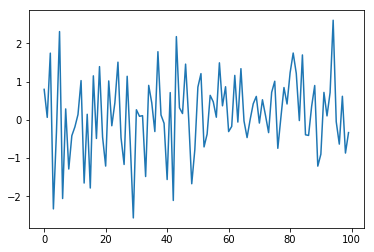

In [137]:
plt.plot(net.words_comps[0][2].data.numpy())
plt.show()

# Create dataset

In [7]:
ls -lh ../data/my_data/

total 13G
-rw-r--r-- 1 fogside fogside  8,1G янв 21 18:08 big_one_file.txt
-rw-r--r-- 1 fogside fogside   40M янв 21 18:22 dict.txt
drwxr-xr-x 3 fogside fogside  4,0K янв 21 18:05 libru/
-rw-r--r-- 1 fogside fogside  3,0M янв 17 17:42 main_contexts_and_test.txt
-rw-r--r-- 1 fogside fogside  623M янв 17 17:43 main_wiki_and_contexts.txt
-rw-r--r-- 1 fogside fogside  620M янв 14 19:34 main_words_wiki_normalized_no_punct.txt
-rw-r--r-- 1 fogside fogside  732M янв 14 18:56 main_words_wiki.txt
-rw-r--r-- 1 fogside fogside 1019M окт 20 00:10 ruwiki_00.txt
-rw-r--r-- 1 fogside fogside  1,1G янв 13 15:06 ruwiki_tokenized.txt
drwxrwxr-x 4 fogside fogside  4,0K янв 19 18:03 НКРЯ/


In [8]:
ls -lh ../models/

total 3,0G
-rw-r--r-- 1 fogside fogside 1,3G дек  8 17:42 fast_text_model.bin
-rw-r--r-- 1 fogside fogside 587M дек  8 17:42 fast_text_model.vec
-rw-r--r-- 1 fogside fogside 923M янв 22 04:51 model_big_one.bin
-rw-r--r-- 1 fogside fogside 171M янв 22 04:51 model_big_one.vec


In [5]:
from pymystem3 import Mystem
stemmer = Mystem()

In [6]:
def get_all_indexes(lst, word):
    res = []
    i = 0
    while(True):
        try:
            i = lst.index(word, i)
            res.append(i)
            i+=1
        except:
            break
    return res

In [7]:
def make_dataset(word, window):
    N = 1669868
    w = stemmer.lemmatize(word)[0]
    counter = 0

    with open("../data/my_data/big_one_file.txt", 'r') as bigf,\
    open("../data/my_data/{}_out.txt".format(word), 'a') as fout:
        for i in tqdm_notebook(range(N)):
            line = bigf.readline().split()
            if w in line:
                idxs = get_all_indexes(line, w)
                for i in idxs:
                    counter+=1
                    # each line is a group of neighbour words with length = 3*window
                    start = max(0, i-1-window) # if 0 is max then all before main word will be selected
                    fout.write(" ".join(line[start:i-1])+" "+" ".join(line[i:i+window])+'\n')
    return counter

In [60]:
make_dataset(word='замок', window=10)

100%|██████████| 1669868/1669868 [01:11<00:00, 23263.62it/s] 


111462

In [6]:
from gensim.models import KeyedVectors
wv = KeyedVectors.load_word2vec_format("../models/model_big_one.vec", binary=False)

In [56]:
with open("../data/my_data/{}_out.txt".format('замок'), 'r') as f:
    lines = f.readlines()

In [7]:
def generate_batch(lines, context_max_len):
    for line in lines:
        line = line.split()
        embedd = []
        for i, w in enumerate(line[:context_max_len]):
            try:
                embedd.append(wv[w])
            except KeyError:
                continue
        yield np.array(embedd)

In [50]:
kek = generate_batch(lines=lines, context_max_len=1)

In [51]:
lol = next(kek)

In [52]:
type(lol)

numpy.ndarray

In [53]:
# lol = np.expand_dims(lol, 0)
lol.shape

(1, 100)

In [54]:
cont_sum = np.mean(lol, axis=0)

In [55]:
cont_sum.shape

(100,)

In [138]:
w_emb = wv['замок'].reshape((1,100))
net = MultiComp(w_emb, 3)
opt = torch.optim.Adam(net.parameters(), lr=1e-4)


n_samples = len(lines)
n_context = 10 # number of words in the context
emb_dim = 100
atts = list()
epoch_num = 1
for epoch in range(epoch_num):
    batch_gen = generate_batch(lines, context_max_len=n_context)
    pbar = tqdm_notebook(batch_gen, total = n_samples)
    print("epoch_num: ", epoch)
    for n, sample in enumerate(pbar):
        # Prepare sample with Variable wrap
    #     sample = Variable(torch.from_numpy(sample.astype(np.float32)))
        net.zero_grad()
        dot_prod, att = net.forward(sample, 0)
        atts.append(att.data.numpy())
        loss = -dot_prod 
        loss.backward()
        opt.step()
        if n % 100 == 99:
            pbar.set_description("loss {:.3f}".format(float(loss.data.numpy())))

HBox(children=(IntProgress(value=0, max=111462), HTML(value='')))

epoch_num:  0



In [237]:
atts = np.array(atts)

In [238]:
atts[-20:]

array([[0.16587138, 0.13672392, 0.6974047 ],
       [0.30780715, 0.6474888 , 0.04470406],
       [0.2365743 , 0.67896855, 0.08445714],
       [0.22418965, 0.34547266, 0.43033764],
       [0.13999598, 0.8056397 , 0.05436434],
       [0.02267888, 0.92723006, 0.05009108],
       [0.02082517, 0.9725045 , 0.00667032],
       [0.43861222, 0.49424314, 0.06714462],
       [0.33819836, 0.43503675, 0.2267649 ],
       [0.06546332, 0.9089217 , 0.02561494],
       [0.25726086, 0.70269173, 0.04004737],
       [0.06654447, 0.93154997, 0.00190554],
       [0.612973  , 0.21143901, 0.17558797],
       [0.3801594 , 0.55371594, 0.06612469],
       [0.00098036, 0.06658698, 0.93243265],
       [0.08590988, 0.7397361 , 0.17435405],
       [0.10580128, 0.15874432, 0.73545444],
       [0.00522046, 0.43229625, 0.5624833 ],
       [0.0517174 , 0.6292154 , 0.3190672 ],
       [0.03816398, 0.32324395, 0.63859206]], dtype=float32)

In [235]:
wv.similar_by_vector(net.n_centroids[0][2].data.numpy(), 30)

AttributeError: 'MultiComp_triplet' object has no attribute 'n_centroids'

In [239]:
net.words_comps[0].data.numpy()[2]

array([-1.2541687 ,  1.8582964 , -0.31258792,  0.2665987 , -0.43048805,
       -0.21790884, -0.04610474, -0.81280226, -1.9765189 , -1.0311747 ,
       -1.2336148 ,  1.083003  ,  1.2231673 , -1.1865796 ,  1.9852815 ,
       -0.364138  ,  0.72365826, -0.4846654 ,  0.06782631, -0.66947746,
       -1.6742879 , -0.04842903,  0.21996294, -1.3484262 , -0.79471636,
        1.014116  ,  0.64308053,  0.01776632,  0.3629273 ,  0.85904515,
       -0.12706737, -0.2522003 , -1.0226461 , -0.30786532,  0.16420737,
        2.1452837 ,  0.8496927 ,  0.6854362 , -1.1959504 ,  0.5445643 ,
       -2.0958505 , -0.55436647,  1.0481219 ,  2.2312617 , -1.0668707 ,
        0.17224905, -1.3053575 , -0.81807315, -0.6041813 ,  1.9998577 ,
        0.16643044,  0.61080855,  0.15806784,  0.2936896 ,  1.3472884 ,
       -0.8041833 , -0.52742165,  0.13929741,  1.0105057 ,  0.05998057,
       -1.9623764 ,  0.1169325 ,  1.0698885 ,  1.1604655 , -1.9462878 ,
        2.1530545 ,  1.7121916 , -2.3145297 , -0.43055144,  1.74

In [240]:
net.words_comps[0].data.numpy()[2]

array([-1.2541687 ,  1.8582964 , -0.31258792,  0.2665987 , -0.43048805,
       -0.21790884, -0.04610474, -0.81280226, -1.9765189 , -1.0311747 ,
       -1.2336148 ,  1.083003  ,  1.2231673 , -1.1865796 ,  1.9852815 ,
       -0.364138  ,  0.72365826, -0.4846654 ,  0.06782631, -0.66947746,
       -1.6742879 , -0.04842903,  0.21996294, -1.3484262 , -0.79471636,
        1.014116  ,  0.64308053,  0.01776632,  0.3629273 ,  0.85904515,
       -0.12706737, -0.2522003 , -1.0226461 , -0.30786532,  0.16420737,
        2.1452837 ,  0.8496927 ,  0.6854362 , -1.1959504 ,  0.5445643 ,
       -2.0958505 , -0.55436647,  1.0481219 ,  2.2312617 , -1.0668707 ,
        0.17224905, -1.3053575 , -0.81807315, -0.6041813 ,  1.9998577 ,
        0.16643044,  0.61080855,  0.15806784,  0.2936896 ,  1.3472884 ,
       -0.8041833 , -0.52742165,  0.13929741,  1.0105057 ,  0.05998057,
       -1.9623764 ,  0.1169325 ,  1.0698885 ,  1.1604655 , -1.9462878 ,
        2.1530545 ,  1.7121916 , -2.3145297 , -0.43055144,  1.74

In [241]:
wv.similar_by_vector(net.words_comps[0].data.numpy()[2], 30)

[('тикаль', 0.36166757345199585),
 ('временной', 0.35686302185058594),
 ('вхождение', 0.35660794377326965),
 ('соблюдаться', 0.3522953391075134),
 ('согласование', 0.3496055603027344),
 ('привязка', 0.34445133805274963),
 ('кастанеда', 0.3425711989402771),
 ('дефакто', 0.3378905653953552),
 ('необъявленный', 0.3370934724807739),
 ('долговременный', 0.3364561200141907),
 ('прецедентный', 0.33643636107444763),
 ('декларироваться', 0.33574363589286804),
 ('задекларировать', 0.33415696024894714),
 ('рассматриваться', 0.3302270770072937),
 ('предусматриваться', 0.32886335253715515),
 ('подписание', 0.3279781937599182),
 ('факто', 0.32715362310409546),
 ('выполняться', 0.3258359134197235),
 ('времяисчисление', 0.3255181312561035),
 ('пролонгация', 0.3248780369758606),
 ('поэтапный', 0.3231258988380432),
 ('размещение', 0.3223552405834198),
 ('формульный', 0.3219674825668335),
 ('установленный', 0.32186293601989746),
 ('согласованный', 0.32162582874298096),
 ('предусматривать', 0.321484059095

In [65]:
from matplotlib import pyplot as plt
%matplotlib inline

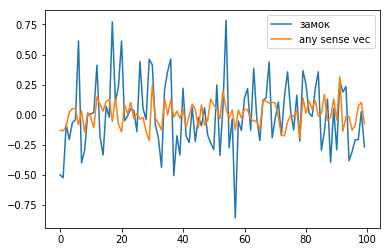

In [233]:
# plt.plot(wv['либуша'], label = 'либуша')
plt.plot(wv['замок'], label = 'замок')
plt.plot(net.words_comps[0].data.numpy()[0]/np.sqrt(np.sum(net.words_comps[0].data.numpy()[0]**2)), label = 'any sense vec')
plt.legend()

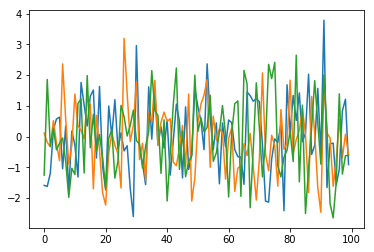

In [232]:
plt.plot(net.words_comps[0].data.numpy()[0])
plt.plot(net.words_comps[0].data.numpy()[1])
plt.plot(net.words_comps[0].data.numpy()[2])
# plt.semilogy()

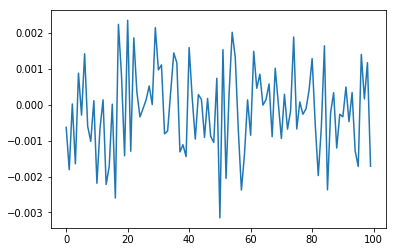

In [231]:
plt.plot(net.words_comps.grad[0][0].data.numpy())

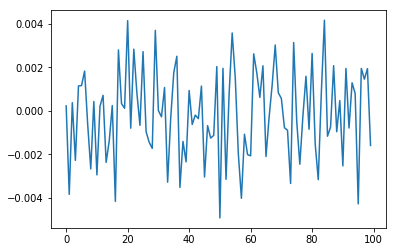

In [230]:
plt.plot(net.words_comps.grad[0][1].data.numpy())

# Triplet

Creates a criterion that measures the triplet loss given an input tensors x1, x2, x3
and a margin with a value greater than 0.


This is used for measuring a relative similarity between samples. A triplet is composed by
`a`, `p` and `n`: anchor, positive examples and negative example respectively.
The shape of all input variables should be :math:`(N, D)`.


The distance swap is described in detail in the paper
`Learning shallow convolutional feature descriptors with triplet losses`_ by V. Balntas, E. Riba et al.

 
$$L(a, p, n) = \frac{1}{N} \left( \sum_{i=1}^N \max \{d(a_i, p_i) - d(a_i, n_i) + {\rm margin}, 0\} \right)$$

where 
    
$$d(x_i, y_i) = \| {\bf x}_i - {\bf y}_i \|_2^2$$

    Args:
        * anchor: anchor input tensor
        * positive: positive input tensor
        * negative: negative input tensor
        p: the norm degree. Default: 2

Shape:
- Input: `(N, D)` where `D = vector dimension`
- Output:`(N, 1)`



    >>> triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)
    >>> input1 = autograd.Variable(torch.randn(100, 128))
    >>> input2 = autograd.Variable(torch.randn(100, 128))
    >>> input3 = autograd.Variable(torch.randn(100, 128))
    >>> output = triplet_loss(input1, input2, input3)
    >>> output.backward()

    .. _Learning shallow convolutional feature descriptors with triplet losses:
        http://www.iis.ee.ic.ac.uk/%7Evbalnt/shallow_descr/TFeat_paper.pdf

In [227]:
# Multi-Component word embeddings

class MultiComp_triplet(nn.Module):
    def __init__(self, word_embeddings_to_comp, n_comp=3):
        """
        word_embeddings_to_comp: word embeddings of the target word;
                                 shape = (n_words,100);
        
        """
        super(MultiComp_triplet, self).__init__()
        self.n_comp = n_comp
        
        n_words, embedding_size = word_embeddings_to_comp.shape
        # expand to duplicate embeddings n_comp times
#         expanded_word_embeddings = np.expand_dims(word_embeddings_to_comp, 1)
#         comp_embeddings = np.tile(expanded_word_embeddings, [1, n_comp, 1])
        
#         # add some noise to components (1/3 of its standard deviations)
#         stds = word_embeddings_to_comp.std(axis=1, keepdims=True).reshape([n_words, 1, 1])
#         comp_embeddings += np.random.randn(n_words, n_comp, embedding_size)#  * stds  / 10
        comp_embeddings = np.random.randn(n_words, n_comp, embedding_size)#  * stds  / 10
        comp_embeddings = comp_embeddings.astype(np.float32)
        
#         self.n_centroids = np.random.randn(n_words, n_comp, embedding_size)#  * stds  / 10
#         self.n_centroids = self.n_centroids.astype(np.float32)
#         self.n_centroids = nn.Parameter(torch.from_numpy(self.n_centroids))
        
        # create variable to use autograd
        self.words_comps = nn.Parameter(torch.from_numpy(comp_embeddings))        
        self.triplet_loss = nn.TripletMarginLoss(margin=0.2, p=2)
                
    def forward(self, context_embeddings, negative_embeddings, word_n):
        """
        context_embeddings: shape = (n_context_words, 100);
        word_n: number of main_word for what the forward is running;
        
        """
        assert context_embeddings.shape[0] == negative_embeddings.shape[0]
        
        cont_sum = torch.mean(context_embeddings, dim=0)
#         scores = torch.matmul(self.n_centroids[word_n], cont_sum)
        scores = torch.matmul(self.words_comps[word_n], cont_sum)
        scores = fn.softmax(scores, 0)
        values, indices = scores.max(0)

        word_curr = torch.matmul(scores, self.words_comps[word_n])
        word_curr /= torch.sqrt(torch.norm(word_curr, p=2))
        
        context_embeddings /= torch.sqrt(torch.norm(context_embeddings, p=2, dim=0))
        
        num_word_contxt = context_embeddings.shape[0]
        word_curr_repeated = word_curr.repeat(num_word_contxt,1)
#         dot_prod = torch.matmul(word_curr, cont_sum.squeeze())/(torch.norm(word_curr, p=1) * torch.norm(cont_sum, p=1))
#         dot_prod -= torch.norm(cont_sum,p=2)
        loss = self.triplet_loss(word_curr_repeated, context_embeddings, negative_embeddings)
        
        return loss, scores

In [220]:
# Multi-Component word embeddings
# Gradients don't work in this case for  self.words_comps

class MultiComp_triplet(nn.Module):
    def __init__(self, word_embeddings_to_comp, n_comp=3):
        """
        word_embeddings_to_comp: word embeddings of the target word;
                                 shape = (n_words,100);
        
        """
        super(MultiComp_triplet, self).__init__()
        self.n_comp = n_comp
        
        n_words, embedding_size = word_embeddings_to_comp.shape
        # expand to duplicate embeddings n_comp times
#         expanded_word_embeddings = np.expand_dims(word_embeddings_to_comp, 1)
#         comp_embeddings = np.tile(expanded_word_embeddings, [1, n_comp, 1])
        
#         # add some noise to components (1/3 of its standard deviations)
#         stds = word_embeddings_to_comp.std(axis=1, keepdims=True).reshape([n_words, 1, 1])
#         comp_embeddings += np.random.randn(n_words, n_comp, embedding_size)#  * stds  / 10
        comp_embeddings = np.random.randn(n_words, n_comp, embedding_size)#  * stds  / 10
        comp_embeddings = comp_embeddings.astype(np.float32)
        
#         self.n_centroids = np.random.randn(n_words, n_comp, embedding_size)#  * stds  / 10
#         self.n_centroids = self.n_centroids.astype(np.float32)
#         self.n_centroids = nn.Parameter(torch.from_numpy(self.n_centroids))
        
        # create variable to use autograd
        self.words_comps = nn.Parameter(torch.from_numpy(comp_embeddings))        
        self.triplet_loss = nn.TripletMarginLoss(margin=0.2, p=2)
                
    def forward(self, context_embeddings, negative_embeddings, word_n):
        """
        context_embeddings: shape = (n_context_words, 100);
        word_n: number of main_word for what the forward is running;
        
        """
        assert context_embeddings.shape[0] == negative_embeddings.shape[0]
        
        cont_sum = torch.mean(context_embeddings, dim=0)
#         scores = torch.matmul(self.n_centroids[word_n], cont_sum)
        scores = torch.matmul(self.words_comps[word_n], cont_sum)
        scores = fn.softmax(scores, 0)
        values, indices = scores.max(0)

#         word_curr = torch.matmul(scores, self.words_comps[word_n])
        
        word_curr = self.words_comps[word_n][indices.data]
        word_curr /= torch.sqrt(torch.norm(word_curr, p=2))
        
        context_embeddings /= torch.sqrt(torch.norm(context_embeddings, p=2, dim=0))
        
        num_word_contxt = context_embeddings.shape[0]
        word_curr_repeated = word_curr.repeat(num_word_contxt,1)
#         dot_prod = torch.matmul(word_curr, cont_sum.squeeze())/(torch.norm(word_curr, p=1) * torch.norm(cont_sum, p=1))
#         dot_prod -= torch.norm(cont_sum,p=2)
        loss = self.triplet_loss(word_curr_repeated, context_embeddings, negative_embeddings)
        
        return loss, scores

# Simple Test2

In [228]:
w_emb = np.random.randn(3, 100)
net = MultiComp_triplet(w_emb)
opt = torch.optim.Adam(net.parameters(), lr=1e-3)


n_samples = 10000
n_context = 20 # number of words in the context
emb_dim = 100
pbar = tqdm_notebook(np.random.randn(n_samples, 2, n_context, emb_dim))

for n, (sample_p, sample_n) in enumerate(pbar):
    # Prepare sample with Variable wrap
    sample_p = Variable(torch.from_numpy(sample_p.astype(np.float32)))
    sample_n = Variable(torch.from_numpy(sample_n.astype(np.float32)))
    
    net.zero_grad()
    dot_prod, att = net.forward(sample_p, sample_n, 0)
    loss = dot_prod
    loss.backward()
    opt.step()
    if n % 100 == 99:
        pbar.set_description("loss {:.3f}".format(float(loss.data.numpy())))
#     print(loss)
#     print("attn: ", att)

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

# Train

In [222]:
def generate_triplet_batch(lines, context_max_len):

    voc_size = len(wv.vocab)
    for line in lines:
        line = line.split()
        embedd_p = []
        context = np.random.choice(line, context_max_len)
        for i, w in enumerate(context):
            try:
                embedd_p.append(wv[w])
            except KeyError:
                continue
        embedd_n = [wv[wv.index2word[i]] for i in np.random.random_integers(0, voc_size-1, len(embedd_p))]
        yield np.array(embedd_p), np.array(embedd_n)

In [229]:
w_emb = wv['замок'].reshape((1,100))
net = MultiComp_triplet(w_emb, 3)
opt = torch.optim.Adam(net.parameters(), lr=1e-4)


n_samples = len(lines)
n_context = 10 # number of words in the context
emb_dim = 100
atts = list()
epoch_num = 1
for epoch in range(epoch_num):
    batch_gen = generate_triplet_batch(lines, context_max_len=n_context)
    pbar = tqdm_notebook(batch_gen, total = n_samples)
    print("epoch_num: ", epoch)
    for n, (sample_p, sample_n) in enumerate(pbar):
        # Prepare sample with Variable wrap
        sample_p = Variable(torch.from_numpy(sample_p.astype(np.float32)))
        sample_n = Variable(torch.from_numpy(sample_n.astype(np.float32)))
        
        net.zero_grad()
        loss, att = net.forward(sample_p, sample_n, 0)
        atts.append(att.data.numpy())
        loss.backward()
        opt.step()
        if n % 100 == 99:
            pbar.set_description("loss {:.3f}".format(float(loss.data.numpy())))

HBox(children=(IntProgress(value=0, max=111462), HTML(value='')))

epoch_num:  0


/home/fogside/virtualenvs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 202435 + 1) instead
  del sys.path[0]
